## Test AWA Environment/Interface Plugins

In [1]:
from plugins.environments.awa_environment import AWAEnvironment
from plugins.interfaces.test_awa_interface import TestAWAInterface

# import data from csv file
import pandas as pd
variable_file = "plugins/environments/awa_variables.csv"
observable_file = "plugins/environments/awa_observables.csv"
variable_info = pd.read_csv(variable_file).set_index("NAME")
observable_info = pd.read_csv(observable_file).set_index("NAME").T

variables = variable_info[["MIN","MAX"]].T.to_dict()
observables = list(observable_info.keys())

for name in variables:
    variables[name] = [variables[name]["MIN"], variables[name]["MAX"]]
variables

{'AWA:Bira3Ctrl:Ch00': [0.0, 1.0],
 'AWA:Bira2Ctrl:Ch00': [0.0, 1.0],
 'AWA:Drive:DS1:Ctrl': [6.05, 9.07],
 'AWA:Drive:DS3:Ctrl': [0.0, 2.5],
 'AWA:Bira3Ctrl:Ch03': [-0.5, 0.5],
 'AWA:Bira3Ctrl:Ch04': [-0.5, 0.5],
 'AWA:Bira3Ctrl:Ch05': [-0.5, 0.5]}

In [2]:
env = AWAEnvironment(variable_file, observable_file, interface=TestAWAInterface())

In [3]:
env.dict()

{'name': 'awa_environment',
 'interface': {'name': 'awa_interface', 'params': {}, 'x': None, 'y': None},
 'variables': {'AWA:Bira3Ctrl:Ch00': [0.0, 1.0],
  'AWA:Bira2Ctrl:Ch00': [0.0, 1.0],
  'AWA:Drive:DS1:Ctrl': [6.05, 9.07],
  'AWA:Drive:DS3:Ctrl': [0.0, 2.5],
  'AWA:Bira3Ctrl:Ch03': [-0.5, 0.5],
  'AWA:Bira3Ctrl:Ch04': [-0.5, 0.5],
  'AWA:Bira3Ctrl:Ch05': [-0.5, 0.5]},
 'observables': ['YAG1:XRMS',
  'YAG1:YRMS',
  'AWAICTMon:Ch1',
  'AWAICTMon:Ch2',
  'AWAICTMon:Ch3',
  'AWAICTMon:Ch4'],
 'params': {},
 'target_charge_PV': 'AWAICTMon:Ch1',
 'target_charge': None,
 'fractional_charge_deviation': 0.1}

In [4]:
env.set_variables({"AWA:Bira3Ctrl:Ch00": 0.5})

In [5]:
env.get_observables(["YAG1:XRMS","YAG1:YRMS"])

{'YAG1:XRMS': 0.5, 'YAG1:YRMS': 0.0, 'AWAICTMon:Ch1': 1.0}

In [6]:
print(env.observables)

['YAG1:XRMS', 'YAG1:YRMS', 'AWAICTMon:Ch1', 'AWAICTMon:Ch2', 'AWAICTMon:Ch3', 'AWAICTMon:Ch4']


## Test with Xopt BE

In [7]:
from xopt import Xopt, Evaluator, VOCS
from xopt.generators.bayesian import BayesianExplorationGenerator

def evaluate(inputs):
    env.set_variables(inputs)
    return env.get_observables(env.observables)

# remove one variable
variables = dict((name, env.variables[name]) for name in ["AWA:Bira3Ctrl:Ch00"])
vocs = VOCS(variables=variables,
            objectives={"YAG1:XRMS":"MINIMIZE"},
            constraints={"YAG1:YRMS":["GREATER_THAN",0.0]})
generator = BayesianExplorationGenerator(vocs)
evaluator = Evaluator(function=evaluate)
X = Xopt(vocs=vocs, evaluator=evaluator, generator=generator)

In [8]:
vocs.dict()

{'variables': {'AWA:Bira3Ctrl:Ch00': [0.0, 1.0]},
 'constraints': {'YAG1:YRMS': ['GREATER_THAN', 0.0]},
 'objectives': {'YAG1:XRMS': 'MINIMIZE'},
 'constants': {},
 'linked_variables': {}}

In [9]:
import pandas as pd
X.evaluate_data(pd.DataFrame({"AWA:Bira3Ctrl:Ch00":[0.0,0.1]}))

,AWA:Bira3Ctrl:Ch00,YAG1:XRMS,YAG1:YRMS,AWAICTMon:Ch1,xopt_runtime,xopt_error
1,0.0,0.0,0.5,1.0,0.000048,False
2,0.1,0.1,0.4,1.0,0.000021,False


In [15]:
for i in range(15):
    X.step()

In [16]:
X.data

,AWA:Bira3Ctrl:Ch00,YAG1:XRMS,YAG1:YRMS,AWAICTMon:Ch1,xopt_runtime,xopt_error
1,0.000000,0.000000,0.500000,1.0,0.000048,False
2,0.100000,0.100000,0.400000,1.0,0.000021,False
3,1.000000,1.000000,-0.500000,1.0,0.000046,False
4,0.365942,0.365942,0.134058,1.0,0.000062,False
5,0.428686,0.428686,0.071314,1.0,0.000062,False
6,0.234039,0.234039,0.265961,1.0,0.000048,False
7,0.473207,0.473207,0.026793,1.0,0.000064,False
8,0.486345,0.486345,0.013655,1.0,0.000068,False
9,0.161796,0.161796,0.338204,1.0,0.000057,False
10,0.000000,0.000000,0.500000,1.0,0.000046,False


<Axes: xlabel='AWA:Bira3Ctrl:Ch00'>

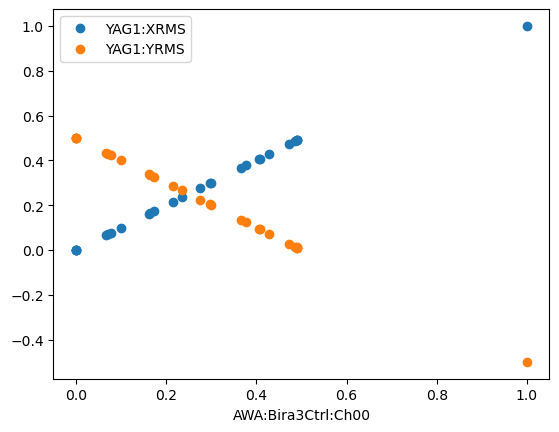

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

X.data.plot(x="AWA:Bira3Ctrl:Ch00", y=["YAG1:XRMS","YAG1:YRMS"],style="o")

In [13]:
model = X.generator.model

In [14]:
model

ModelListGP(
  (models): ModuleList(
    (0-1): 2 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)